In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

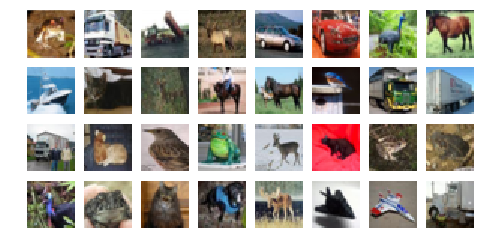

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

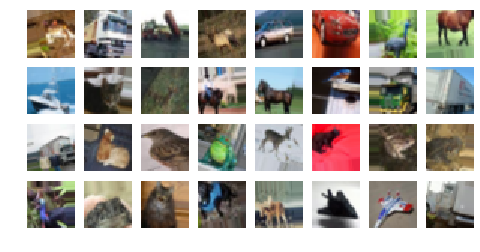

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

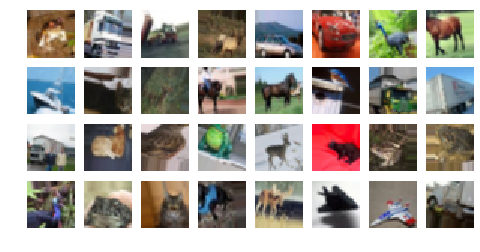

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [55]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

In [56]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [57]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(x_train)


In [58]:
img_rows, img_cols, channels = 32, 32, 3
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [59]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_rows, img_cols, channels)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)       

In [61]:
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch = len(x_train) / 256, epochs=20, 
                    validation_data=(x_test, y_test))

Epoch 1/20
196/195 [==============================] - 123s 629ms/step - loss: 2.3734 - accuracy: 0.1115 - val_loss: 2.2971 - val_accuracy: 0.1094
Epoch 2/20
196/195 [==============================] - 122s 623ms/step - loss: 2.3006 - accuracy: 0.1373 - val_loss: 2.1056 - val_accuracy: 0.2376
Epoch 3/20
196/195 [==============================] - 113s 578ms/step - loss: 1.9531 - accuracy: 0.2844 - val_loss: 1.7372 - val_accuracy: 0.3639
Epoch 4/20
196/195 [==============================] - 114s 580ms/step - loss: 1.7949 - accuracy: 0.3490 - val_loss: 1.4712 - val_accuracy: 0.4595
Epoch 5/20
196/195 [==============================] - 119s 606ms/step - loss: 1.6584 - accuracy: 0.4002 - val_loss: 1.5362 - val_accuracy: 0.4427
Epoch 6/20
196/195 [==============================] - 116s 590ms/step - loss: 1.5823 - accuracy: 0.4294 - val_loss: 1.4216 - val_accuracy: 0.5062
Epoch 7/20
196/195 [==============================] - 120s 610ms/step - loss: 1.5137 - accuracy: 0.4583 - val_loss: 1.4144 -

In [64]:
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]


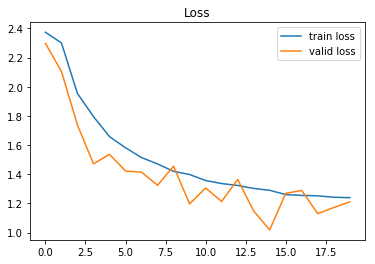

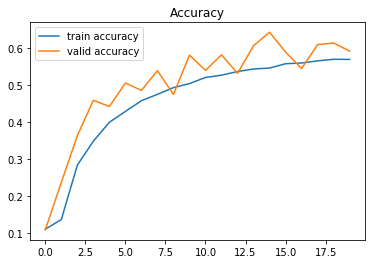

In [66]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [67]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

In [68]:
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch = len(x_train) / 256, epochs=20, 
                    validation_data=(x_test, y_test))

Epoch 1/20
196/195 [==============================] - 131s 669ms/step - loss: 1.1048 - accuracy: 0.6180 - val_loss: 1.0668 - val_accuracy: 0.6449
Epoch 2/20
196/195 [==============================] - 121s 617ms/step - loss: 1.1056 - accuracy: 0.6161 - val_loss: 0.9381 - val_accuracy: 0.6734
Epoch 3/20
196/195 [==============================] - 128s 654ms/step - loss: 1.0802 - accuracy: 0.6266 - val_loss: 0.9381 - val_accuracy: 0.6753
Epoch 4/20
196/195 [==============================] - 128s 652ms/step - loss: 1.0720 - accuracy: 0.6297 - val_loss: 0.9032 - val_accuracy: 0.6979
Epoch 5/20
196/195 [==============================] - 133s 679ms/step - loss: 1.0629 - accuracy: 0.6338 - val_loss: 1.0190 - val_accuracy: 0.6591
Epoch 6/20
196/195 [==============================] - 122s 621ms/step - loss: 1.0585 - accuracy: 0.6382 - val_loss: 1.1919 - val_accuracy: 0.6267
Epoch 7/20
196/195 [==============================] - 120s 610ms/step - loss: 1.0595 - accuracy: 0.6375 - val_loss: 0.8604 -

In [69]:
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]


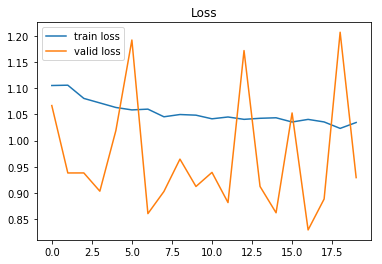

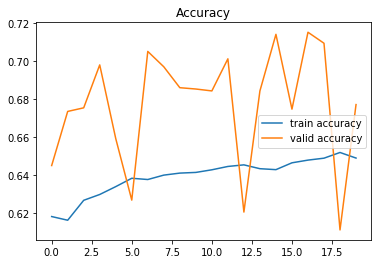

In [70]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()